
============================== Data =================================

tensor([0.4613, 0.4608, 0.5681, 0.3844, 0.2831, 0.1053, 0.2534, 0.7036, 0.5753,
        0.6076, 0.9346, 0.5537, 0.1396, 0.8495, 0.3672, 0.8858, 0.0783, 0.3792,
        0.4151, 0.2365, 0.8134, 0.3391, 0.2043, 0.4013, 0.3198, 0.1359, 0.6351,
        0.0574, 0.5154, 0.1748, 0.7177, 0.7105, 0.5172, 0.3638, 0.9314, 0.6911,
        0.3815, 0.1068, 0.9714, 0.3022, 0.8524, 0.9535, 0.3462, 0.2386, 0.8973,
        0.5447, 0.7929, 0.8532, 0.0438, 0.8510, 0.6248, 0.3946, 0.4346, 0.3411,
        0.1939, 0.7444, 0.6434, 0.2740, 0.3495, 0.2749, 0.6627, 0.9112, 0.7186,
        0.4651], dtype=torch.float64, requires_grad=True)


Initial entropy loss: 5.351409912109375


Epoch    0/100 Cost: 0.484375
Epoch   10/100 Cost: 0.390625
Epoch   20/100 Cost: 0.390625
Epoch   30/100 Cost: 0.390625
Epoch   40/100 Cost: 0.390625
Epoch   50/100 Cost: 0.390625
Epoch   60/100 Cost: 0.390625
Epoch   70/100 Cost: 0.390625
Epoch   80/100 Cost: 0.390

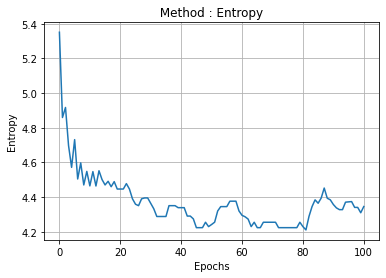

In [ ]:
import string
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from keras import backend as K
# %matplotlib inline

# Data

print("\n============================== Data =================================\n")
test_f = torch.rand(dtype=torch.float64, requires_grad=True, size=(64,))
print(test_f)
print("\n=====================================================================\n")

############################################################

class EntropyLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx, activityMatrix):
        #dims = test_f.shape[0]
        #for batch in dims:
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        

        normalized_tensor = 63*(activityMatrix - min)/(max-min)
        normalized_tensor = torch.round(normalized_tensor)
        normalized_tensor = normalized_tensor.to(int)

        #print("==========normalization phase==========")

        norm_bincounts = torch.bincount(normalized_tensor)
        #print(normalized_tensor)
        #print(norm_bincounts)
        pixel_num = activityMatrix.shape[0] # test if shape is right
        #print("pixel num:",pixel_num)
        prob_bincounts = torch.true_divide(norm_bincounts, pixel_num)
        log_bincounts = torch.log2(prob_bincounts) 
        entropyMatrix = log_bincounts*prob_bincounts
        entropyMatrix[entropyMatrix != entropyMatrix] = 0 # no nan.
        entropyMatrix = -1 * entropyMatrix
        entropy = torch.sum(entropyMatrix)
        
        ctx.save_for_backward(activityMatrix, norm_bincounts, log_bincounts)
        #print("============finished calculating entropy")
        return entropy

    @staticmethod    
    def backward(ctx, grad_output):
        activityMatrix, norm_bincounts, log_bincounts,  = ctx.saved_tensors
        dp = log_bincounts - np.log(2)
        df = log_bincounts.clone()
        pixel_num = activityMatrix.shape[0]
        #print("log bincounts:",dp)
        for i in range(norm_bincounts.shape[0]):
            if i == 0:
                df[0] = torch.true_divide(norm_bincounts[0], pixel_num)
            else:
                df[i] = (df[i] - df[i-1])/pixel_num
        #df[df != df] = 0
        #df[df == '-inf'] = 0
        #df[df == 'inf'] = 0
        #print("dp:",dp)
        #print("df: ",df)
        #dnorm = torch.bincount(df)
        
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        dnorm = 63/(max-min)
        #print(dnorm)
        temp = dp*df*dnorm
        #print(temp)
        grad_input = grad_output/temp
        grad_input[grad_input != grad_input] = 0
        #print(grad_input)
        #grad_input = 64*(grad_input)/min   

        return grad_input #dimension이 activityMatrix 맞기만 하면 됨
    
loss = EntropyLoss.apply

testing_loss = loss(test_f)
print("Initial entropy loss: {}\n".format(testing_loss))
testing_loss.backward()
print("=====================================================================\n")

##########################################################
class LogQuantization(object):
    def __init__(self, bitwidth, fsr):
        self.bitwidth = bitwidth
        self.fsr = fsr

    def __call__(self, w):
        # filter the variables to get the ones you want
        
        temp = np.zeros(w.shape)
        #print(len(w.shape))
        if len(w.shape) <= 1:
            for i in range(len(temp)):
                    var = w[i]
                    #print("before: ",var)
                    if var.item() != 0: # if var != 0
                        temp[i] = 2**(self.Clip(torch.round(np.log2(abs(var))), self.fsr-2**self.bitwidth, self.fsr))
                        if var < 0:
                            temp[i] = -1*temp[i]
                    else:
                        temp[i] = 0
        else:
            for j in range(len(temp)):
                for i in range(len(temp[j])):
                    var = w[j][i]
                    #print("before: ",var)
                    if var.item() != 0: # if var != 0
                        temp[j][i] = 2**(self.Clip(torch.round(np.log2(abs(var))), self.fsr-2**self.bitwidth, self.fsr))
                        if var < 0:
                            temp[j][i] = -1*temp[j][i]
                    else:
                        temp[j][i] = 0
        
        return torch.from_numpy(temp).float()
        
    def Clip(self,x,minimum,maximum):
        if x <= minimum:
            x = 0
        elif x >= maximum:
            x = maximum-1
        return x

my_constraint = LogQuantization(8,128)



##############################################

# Parameter
model = nn.Sequential(nn.Linear(64,64))
optimizer = optim.Adam(model.parameters(),lr=0.03)
###model.apply(my_constraint)

# First Entropy
losses = []
first = EntropyLoss.apply(test_f) # first entropy 넣기
losses.append(first.item())

# Custom Loss function
def loss_func(data, decoded):
    cossim_loss = nn.CosineEmbeddingLoss() # Pytorch built-in Cosine similarity for calculating loss 
    y = torch.tensor(np.ones((data.shape[0], 1)), dtype=torch.float)
    mse_loss = nn.MSELoss()
    loss = cossim_loss(data, decoded, y)
            
    return loss

# Epochs
epochs = 100
for epoch in range(epochs):
  optimizer.zero_grad() # Gradient Descent 하기 전 gradient 0으로 설정
  y_pred = model(test_f.float()) # forward 연산

  #
  ny_pred = y_pred.view(-1,1)
  ntest_f = test_f.view(-1,1)
  cossim_loss = nn.CosineEmbeddingLoss()
  y = torch.tensor(np.ones((test_f.shape[0],1)), dtype=torch.float,requires_grad=True)
  y = y * -1
  loss = cossim_loss(ntest_f,ny_pred,y) # Loss를 그냥 Entropy로 바로 줌
  loss.backward() # backpropagation

  nny_pred = y_pred.view(-1,)
  entropy = EntropyLoss.apply(nny_pred)

  #
  optimizer.step() # model의 parameter들을 update 

  if epoch % (epochs/10) == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, loss.item()
        ))

  losses.append(entropy.item())

#############################################

print("\n===========================Every Entropy==============================\n")
i = 0
for i in range(0,len(losses)):
    if i % 5 !=0:
        print(losses[i], end= "  ")
        i += 1
    else:
        print("\n")
        print(losses[i], end ="  ")
        i += 1


# min_list = min(losses)

print("\n\nThe Initial Entropy : {}".format(losses[0]))
print("The Final Entropy : {}\n".format(losses[-1]))

print("\n\n=====================================================================\n")
#############################################

method = "Entropy"

plt.title(" Method : {} ".format(method))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Entropy")
plt.grid(True)
